In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mdtraj as md

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = '14'

### Define functions

In [3]:
def get_rmsd_mean_std(variant,conf,domain):
    """
    Get mean and standard deviation of RMSD to 
    crystal structure across three individual runs.
    """
    # loop over runs and get rmsd data for each
    rmsd_all_replica_list = []
    for run in ["run1","run2","run3"]:
        rmsd_arr = np.load(f"analysis_output/rmsd_all_res/{variant}_{conf}_{run}_{domain}_crystal.npy")
        rmsd_all_replica_list.append(rmsd_arr * 10) # convert to Ångstrøm
    
    # calculate RMSD average for each run
    rmsd_replica_mean = np.mean(rmsd_all_replica_list,axis=1)
    
    # calculate mean and std of run averages
    rmsd_all_mean = np.mean(rmsd_replica_mean)
    rmsd_all_std = np.std(rmsd_replica_mean,ddof=1)

    return rmsd_all_mean, rmsd_all_std, rmsd_replica_mean

def rmsd_mean_std_all_variants(conf,domain):
    """
    Loop over all simulated GCK variants and
    make lists with RMSD averages and standard
    deviations for all variants. 
    """
    # define variants
    variants = ["gck_wt","gck_D158A","gck_G162Q","gck_A173F","gck_G175E","gck_V455M"]

    # make lists
    rmsd_all_mean_list = []
    rmsd_all_std_list = []
    rmsd_replica_mean_list = []
    
    # loop over variants
    for variant in variants:

        # get RMSD mean and std for variant across individual runs
        rmsd_all_mean, rmsd_all_std, rmsd_replica_mean = get_rmsd_mean_std(variant,conf,domain)

        # append
        rmsd_all_mean_list.append(rmsd_all_mean)
        rmsd_all_std_list.append(rmsd_all_std)
        rmsd_replica_mean_list.append(rmsd_replica_mean)

    return rmsd_all_mean_list, rmsd_all_std_list, rmsd_replica_mean_list, variants

def plot_rmsd_mean(conf,domain,ymin,ymax):
    """
    Plot average RMSDs to crystal structures
    for all simulated GCK variants. Show both
    RMSD means from individual simulations and means
    across three individual runs for each variant. 
    """
    # get RMSD mean and std across runs for all variants
    rmsd_all_mean_list, rmsd_all_std_list, rmsd_replica_mean_list, variants = rmsd_mean_std_all_variants(conf,domain)

    # check variant names
    if variants == ["gck_wt","gck_D158A","gck_G162Q","gck_A173F","gck_G175E","gck_V455M"]:
        variants_names = ["WT","D158A","G162Q","A173F","G175E","V455M"]        

    # set plotting parameters
    plt.rcParams['font.size'] = '13'
    plt.figure(figsize=(5,4))

    # plot mean and std across runs as function of variants 
    plt.errorbar(x = variants_names, y = rmsd_all_mean_list, yerr = rmsd_all_std_list,
                 marker='s',ms=12,linewidth=0,elinewidth=1,capsize=5,
                 color="grey",markeredgecolor="black")

    # plot mean per run as function of variants
    plt.errorbar(x = np.repeat(variants_names,repeats=3), y = np.concatenate(rmsd_replica_mean_list), 
                 color="tab:orange", marker='o', ms=8,linewidth=0, markeredgecolor="black")

    # set ticks, limits and labels
    plt.xticks(rotation=-45)
    plt.ylim(ymin,ymax)
    plt.ylabel("RMSD (Å)")
    plt.title(f"{domain} in {conf}")

    plt.tight_layout()
    plt.show()

def get_angle_dist_calc(conf, obs_name):
    """
    Get mean and std for all simulated GCK variants
    of a given observable obs_name, which can be 
    either dist, angle1 or angle2.
    """
    # lists with mean and std across runs
    obs_mean_list = []
    obs_std_list = []

    # list with means from individual runs
    obs_mean_all_replicas_list = [] 

    # list with variant names
    variant_name_list = []

    # loop over variants
    for variant in ["gck_wt","gck_D158A","gck_G162Q","gck_A173F","gck_G175E","gck_V455M"]:
        
        obs_replica_list = []
        variant_replica_list = []

        # loop over runs
        for run in ["run1","run2","run3"]:
    
            # read data for observable
            t, obs = np.loadtxt(f"analysis_output/angles+dists/{variant}_{conf}_{run}_{obs_name}.txt",unpack=True)

            # convert from nm to Å
            if obs_name == "dist":
                obs = obs * 10

            # append
            obs_replica_list.append(obs)
            variant_replica_list.append(variant[4:])
            
        # calculate mean of observable for each run
        obs_replica_mean_list = np.mean(obs_replica_list,axis=1)

        # calculate mean and std across runs
        obs_replica_mean = np.mean(obs_replica_mean_list)
        obs_replica_std = np.std(obs_replica_mean_list,ddof=1)

        # append
        obs_mean_list.append(obs_replica_mean)
        obs_std_list.append(obs_replica_std)
        obs_mean_all_replicas_list.append(obs_replica_mean_list)
        variant_name_list.append(variant_replica_list)

    return obs_mean_list, obs_std_list, obs_mean_all_replicas_list, variant_name_list

def plot_angle_dist_means(conf, obs_name, ylabel, ymin, ymax):
    """
    Plot observable averages for all simulated GCK variants.
    Show both averages from individual simulations and 
    averages across three runs for each variant. obs_name 
    can be either dist, angle1 or angle2.
    """
    # get means and standard deviations of obs for all variants
    obs_mean_list, obs_std_list, obs_mean_all_replicas_list, variant_name_list = get_angle_dist_calc(conf, obs_name)

    # set plotting parameters
    plt.rcParams['font.size'] = '13'
    plt.figure(figsize=(5,4))

    # plot mean and std across runs as function of variants 
    plt.errorbar(x = np.array(variant_name_list)[:,0], y = obs_mean_list, yerr = obs_std_list,
                 marker='s',ms=12,linewidth=0,elinewidth=1,capsize=5,
                 color="grey",markeredgecolor="black")

    # plot mean per run as function of variants
    plt.errorbar(x = np.concatenate(variant_name_list), y = np.concatenate(obs_mean_all_replicas_list), 
                 color="tab:orange", marker='o', ms=8,linewidth=0, markeredgecolor="black")

    # set ticks, limits and labels
    plt.ylim(ymin,ymax)
    plt.xticks(rotation=-45)
    plt.ylabel(ylabel)
    plt.title(conf)
    
    plt.tight_layout()
    plt.show()

def get_rmsf_mean_std(variant,conf):
    """
    Read calculated RMSF values, convert from nm to 
    Å, and calculate average and standard deviation
    over the three individual runs. 
    """
    # define empty rmsd array
    rmsf_arr_all = np.zeros((3,465))
    rmsf_arr_all[:] = np.nan
    
    # read data
    for run in ["run1","run2","run3"]:
        rmsf_arr = np.load(f"analysis_output/rmsf_all_res/{variant}_{conf}_{run}.npy")
        rmsf_arr_all[int(run[-1])-1] = rmsf_arr * 10 # nm to Å
    
    # calculate mean and std over three runs
    rmsf_mean = np.nanmean(rmsf_arr_all,axis=0) 
    rmsf_std = np.nanstd(rmsf_arr_all,axis=0,ddof=1) 

    return rmsf_mean, rmsf_std

def plot_rmsf_data(variant1, conf1, variant2, conf2, i, ymin, ymax):
    """
    Plot RMSF as function of residue number, comparing
    variant1 in conformation conf1 to variant2 in 
    conformation conf2. i is an int that sets color. 
    """
    # make figure
    plt.figure(figsize=(9,3))

    # load and plot rmsf data for variant1 in conf1
    rmsf_mean_1, rmsf_std_1 = get_rmsf_mean_std(variant1,conf1)
    plt.errorbar(x=range(1,len(rmsf_mean_1)+1),y=rmsf_mean_1,yerr=rmsf_std_1,
                 marker='o',ms=5,linewidth=0,elinewidth=1,capsize=2,
                 label=f"{variant1} in {conf1}",color="dimgray")
    
    # load and plot rmsf data for variant2 in conf2
    rmsf_mean_2, rmsf_std_2 = get_rmsf_mean_std(variant2,conf2)
    plt.errorbar(x=range(1,len(rmsf_mean_2)+1),y=rmsf_mean_2,yerr=rmsf_std_2,
                 marker='o',ms=3,linewidth=0,elinewidth=1,capsize=2,
                 label=f"{variant2} in {conf2}",color=colors_set2[i])
    
    # mark position of variant
    if variant2 != "gck_wt":
        plt.vlines(x = int(variant2[5:-1]), ymin = 0, ymax = 8, color="grey", ls="dashed",alpha=0.5)

    # define labels, ticks, legends
    plt.xlabel("Residue number")
    plt.ylabel(r"C$_\alpha$ RMSF (Å)")
    plt.ylim(ymin,ymax)
    plt.xticks(ticks=[1,50,100,150,200,250,300,350,400,450],
               labels=[1,50,100,150,200,250,300,350,400,450])
    
    plt.tight_layout()
    plt.show()

def plot_rmsf_data_zoom(variant1, conf1, variant2, conf2, i, res_min, res_max, ymin, ymax):
    """
    Plot RMSF as function of residue number for residues in 
    interval from res_min to res_max, comparing
    variant1 in conformation conf1 to variant2 in 
    conformation conf2. i is an int that sets color. 
    """
    # make figure
    plt.figure(figsize=(4,3))

    # load and plot rmsf data for variant1 in conf1
    rmsf_mean_1, rmsf_std_1 = get_rmsf_mean_std(variant1,conf1)
    plt.errorbar(x=range(1,len(rmsf_mean_1)+1),y=rmsf_mean_1,yerr=rmsf_std_1,
                 marker='o',ms=5,linewidth=0,elinewidth=1,capsize=2,
                 label=f"{variant1} in {conf1}",color="dimgray")
    
    # load and plot rmsf data for variant2 in conf2
    rmsf_mean_2, rmsf_std_2 = get_rmsf_mean_std(variant2,conf2)
    plt.errorbar(x=range(1,len(rmsf_mean_2)+1),y=rmsf_mean_2,yerr=rmsf_std_2,
                 marker='o',ms=3,linewidth=0,elinewidth=1,capsize=2,
                 label=f"{variant2} in {conf2}",color=colors_set2[i])

    # identify min and max rmsf values
    rmsf_min = np.max([np.nanmin(rmsf_mean_1),np.nanmin(rmsf_mean_2)])
    rmsf_max = np.max([np.nanmax(rmsf_mean_1),np.nanmax(rmsf_mean_2)])
    
    # mark position of variant
    if variant2 != "gck_wt":
        plt.vlines(x = int(variant2[5:-1]), ymin = 0, ymax = 4, color="grey", ls="dashed",alpha=0.5)

    # define labels, ticks, legends
    plt.xlabel("Residue number")
    plt.ylabel(r"C$_\alpha$ RMSF (Å)")
    plt.ylim(0.2,3.1)
    plt.xlim(res_min-0.5,res_max+0.5)
    plt.ylim(ymin, ymax)
    
    plt.tight_layout()
    plt.show()

def plot_rmsf_data_corr(variant1, conf1, variant2, conf2, i):
    """
    Plot RMSFs for variant1 in conformation conf1 
    against RMSFs for variant2 in conformation conf2.
    i is an int that sets color. 
    """
    # make figure
    plt.figure(figsize=(3,3))

    # get RMSF data
    rmsf_mean_1, rmsf_std_1 = get_rmsf_mean_std(variant1,conf1)
    rmsf_mean_2, rmsf_std_2 = get_rmsf_mean_std(variant2,conf2)

    # idendity min and max RMSFs to set xlim and ylim
    rmsf_min = np.max([np.nanmin(rmsf_mean_1),np.nanmin(rmsf_mean_2)])
    rmsf_max = np.max([np.nanmax(rmsf_mean_1),np.nanmax(rmsf_mean_2)])

    # plot RMSFs
    plt.errorbar(x=rmsf_mean_1,y=rmsf_mean_2,xerr=rmsf_std_1,yerr=rmsf_std_2,
                 marker='o',ms=2,linewidth=0,elinewidth=1,capsize=2,
                 label=f"{variant2} in {conf2}",color=colors_set2[i],
                 markeredgecolor="black",markeredgewidth=0.25)

    # plot diagonal
    r = np.arange(-7,7,0.01)
    plt.plot(r,r,color="dimgray")

    # set labels, limits, log scale
    plt.xlabel(r"WT C$_\alpha$ RMSF (Å)")
    plt.ylabel(rf"{variant2[4:]} C$_\alpha$ RMSF (Å)")
    plt.xlim(rmsf_min-0.1,rmsf_max+0.4)
    plt.ylim(rmsf_min-0.1,rmsf_max+0.4)
    plt.xscale("log")
    plt.yscale("log")
    
    plt.tight_layout()
    plt.show()

## Plot RMSD averages

Plot average RMSDs to crystal structures for all GCK variants. 
Plotting is done seperately for each domain and conformation. 

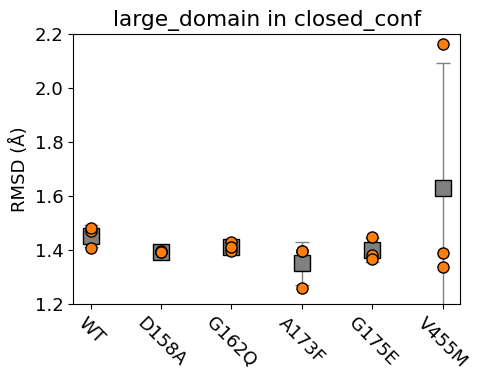

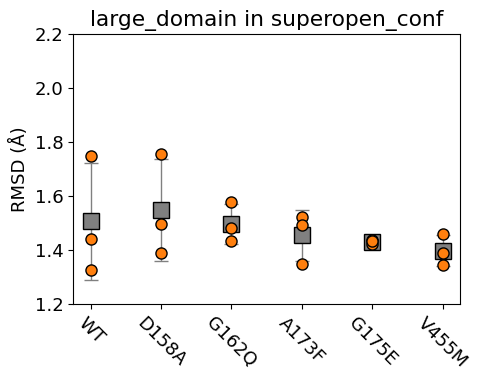

In [4]:
domain = "large_domain"
for conf in ["closed_conf","superopen_conf"]:
    plot_rmsd_mean(conf,domain,1.2,2.2)

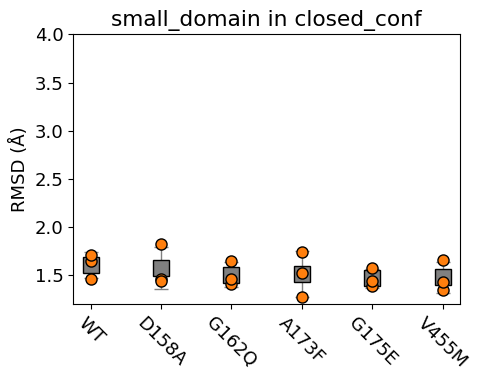

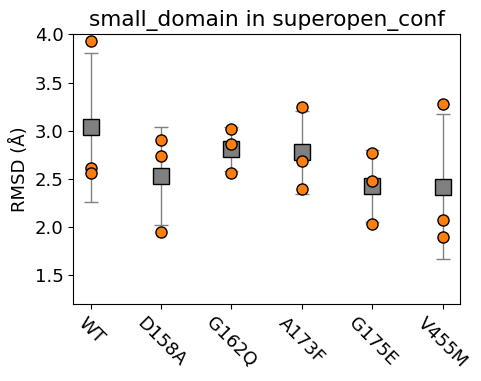

In [5]:
domain = "small_domain"
for conf in ["closed_conf","superopen_conf"]:
    plot_rmsd_mean(conf,domain,1.2,4)

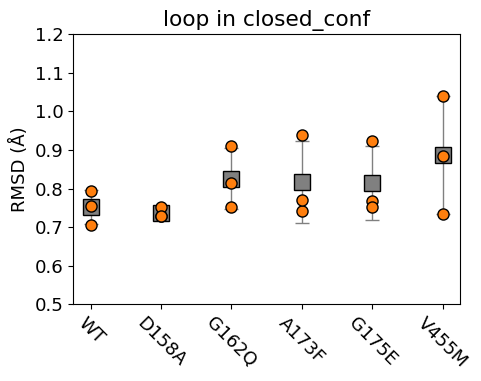

In [6]:
domain = "loop"
conf = "closed_conf"
plot_rmsd_mean(conf,domain,0.5,1.2)

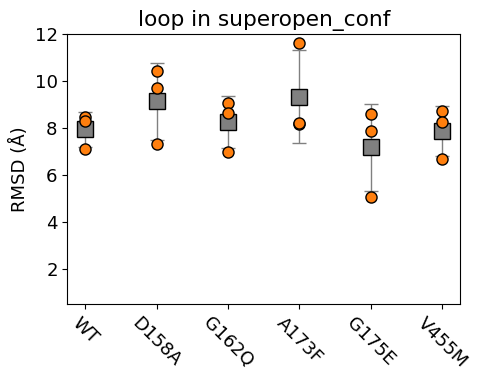

In [7]:
domain = "loop"
conf = "superopen_conf"
plot_rmsd_mean(conf,domain,0.5,12)

## Plot opening angle and 159-452 distance

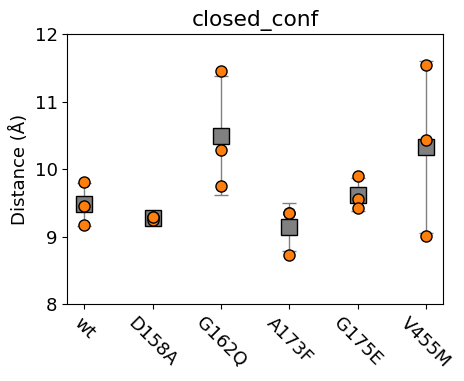

In [8]:
plot_angle_dist_means("closed_conf", "dist", "Distance (Å)", 8, 12)

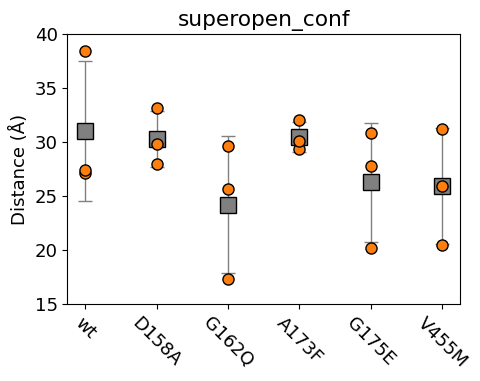

In [9]:
plot_angle_dist_means("superopen_conf", "dist", "Distance (Å)", 15, 40)

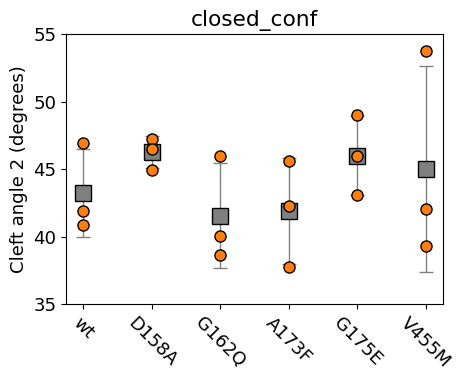

In [10]:
plot_angle_dist_means("closed_conf", "angle2", "Cleft angle 2 (degrees)", 35, 55)

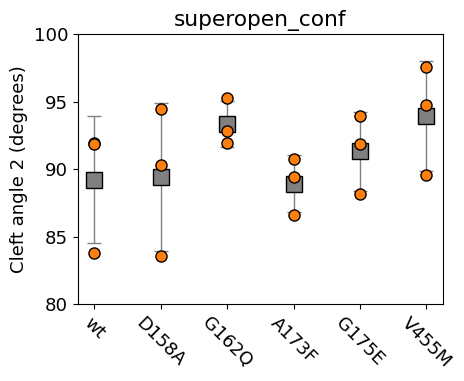

In [11]:
plot_angle_dist_means("superopen_conf", "angle2", "Cleft angle 2 (degrees)", 80, 100)

## Plot RMSFs

In [13]:
import seaborn as sns
colors_set2 = sns.color_palette("Set2")

#### Plot RMSFs for WT GCK comparing closed and superopen conformations

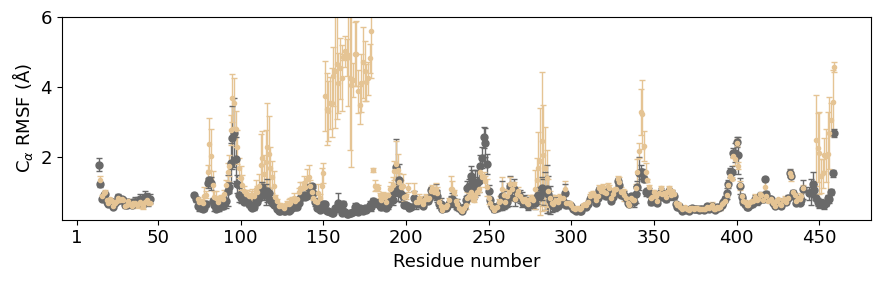

In [14]:
# entire sequence
plot_rmsf_data("gck_wt","closed_conf","gck_wt","superopen_conf", 6, 0.2, 6)

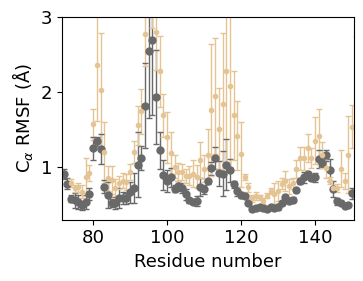

In [15]:
# zoom on small domain
plot_rmsf_data_zoom("gck_wt","closed_conf","gck_wt","superopen_conf",6,72,150,0.3,3)

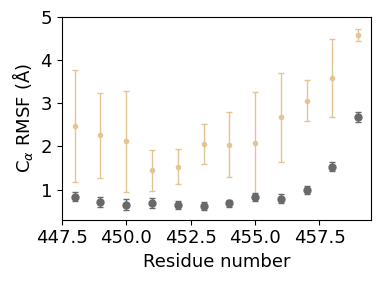

In [16]:
# alpha helix 13
plot_rmsf_data_zoom("gck_wt","closed_conf","gck_wt","superopen_conf",6,448,459,0.3,5)

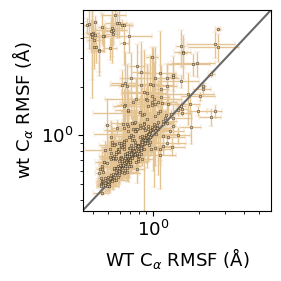

In [17]:
# entire sequence
plot_rmsf_data_corr("gck_wt","closed_conf","gck_wt","superopen_conf", 6)

#### Plot RMSFs to compare WT and variants of GCK

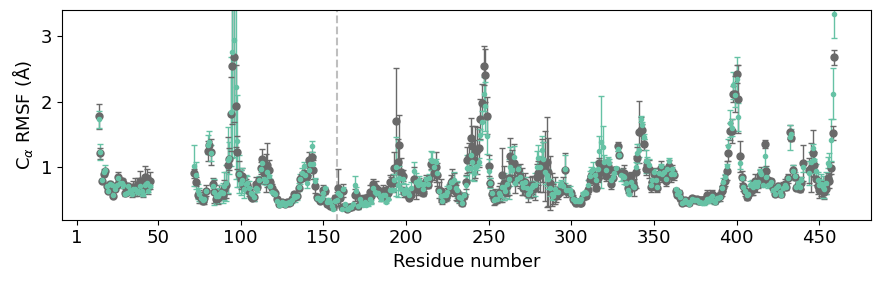

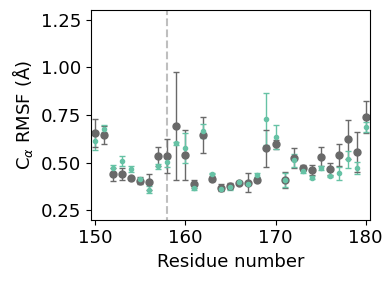

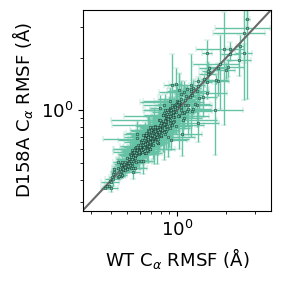

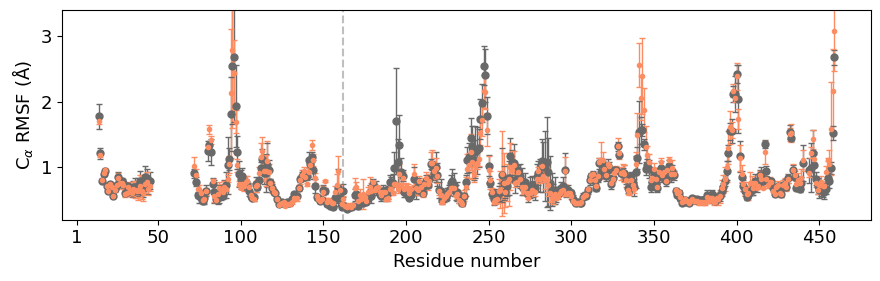

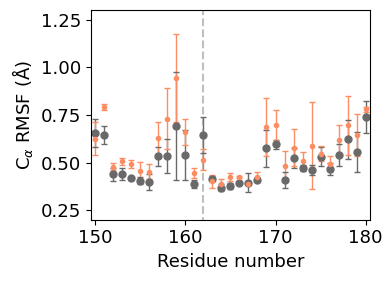

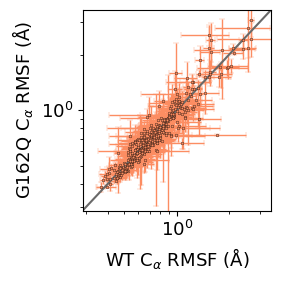

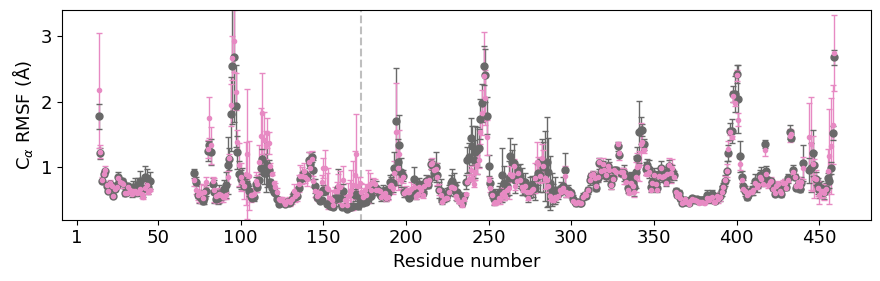

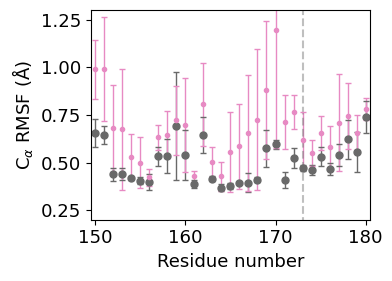

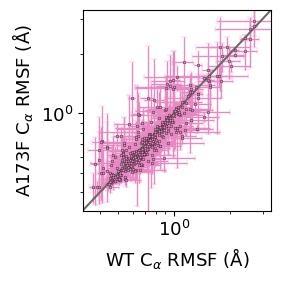

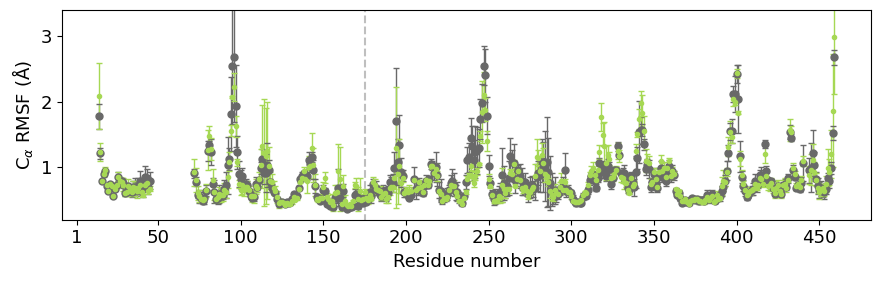

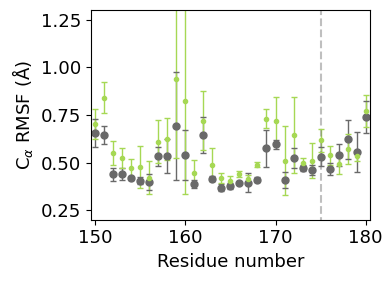

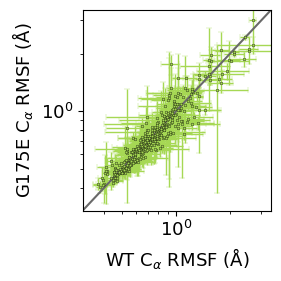

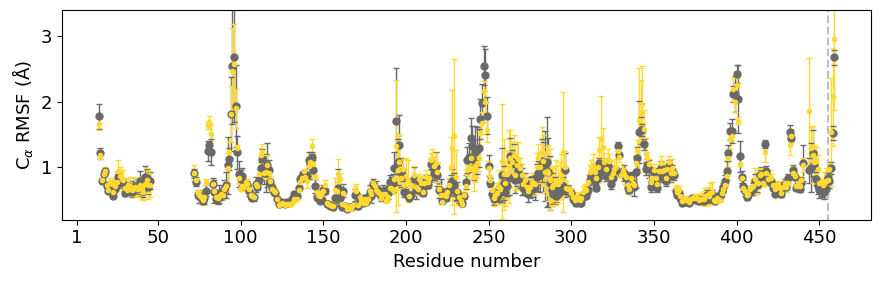

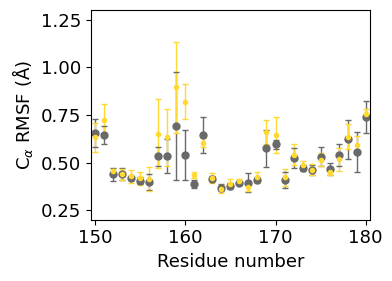

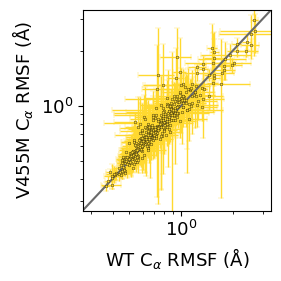

In [18]:
# make plots for closed conf

variants = ["gck_D158A","gck_G162Q","gck_A173F","gck_G175E","gck_V455M"]
color_idx = [0,1,3,4,5]

for variant,col_idx in zip(variants,color_idx):
    plot_rmsf_data("gck_wt","closed_conf",variant,"closed_conf",col_idx,0.2,3.4)
    plot_rmsf_data_zoom("gck_wt","closed_conf",variant,"closed_conf",col_idx,150,180,0.2,1.3)
    plot_rmsf_data_corr("gck_wt","closed_conf",variant,"closed_conf",col_idx)

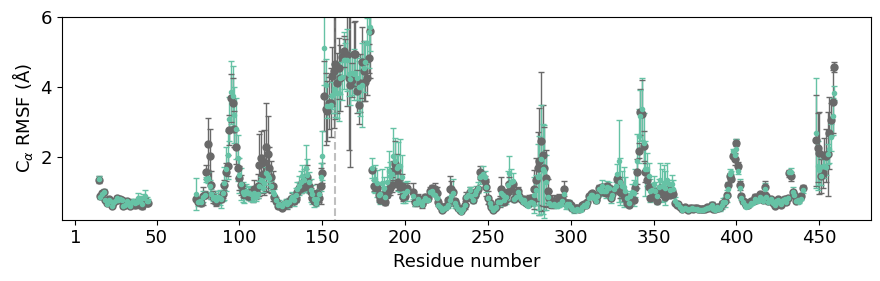

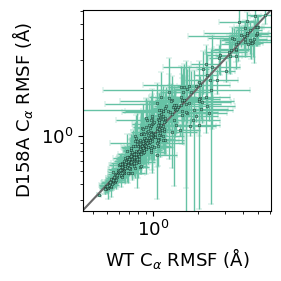

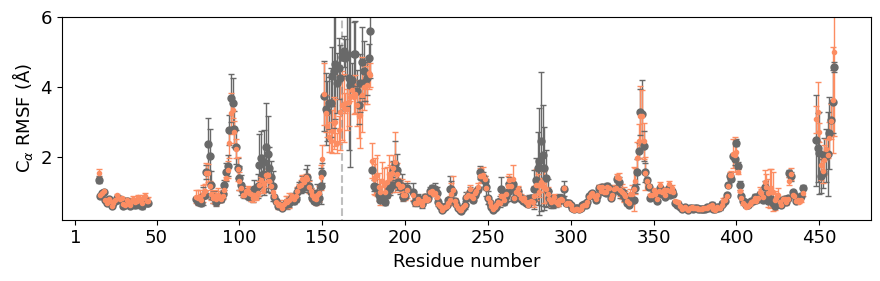

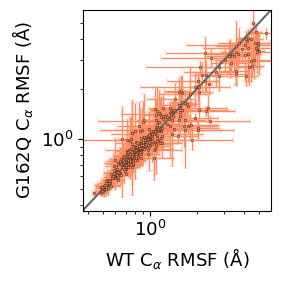

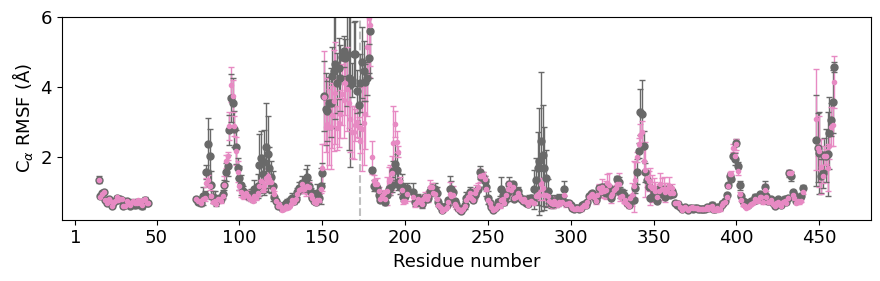

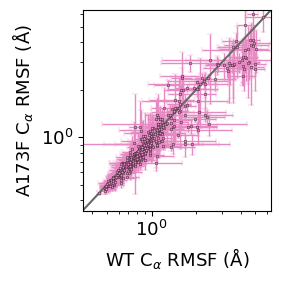

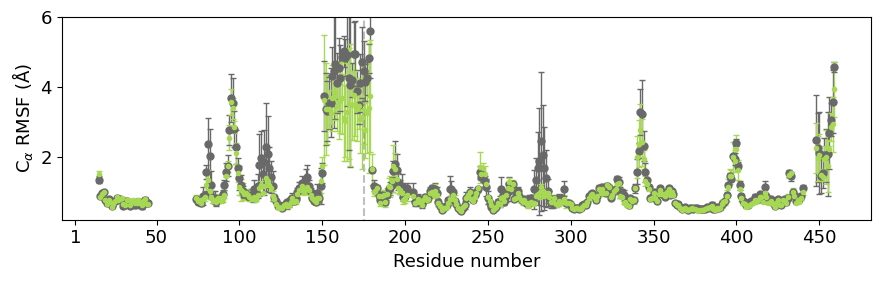

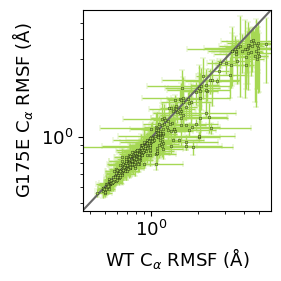

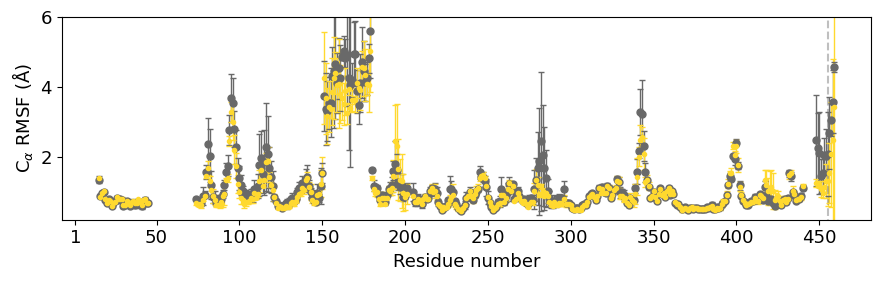

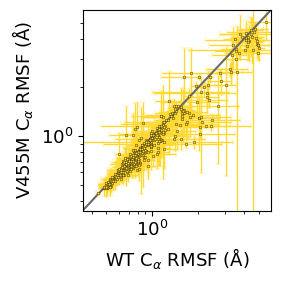

In [19]:
# make plots for superopen conf
variants = ["gck_D158A","gck_G162Q","gck_A173F","gck_G175E","gck_V455M"]
color_idx = [0,1,3,4,5]

for variant,col_idx in zip(variants,color_idx):
    plot_rmsf_data("gck_wt","superopen_conf",variant,"superopen_conf",col_idx,0.2,6)
    plot_rmsf_data_corr("gck_wt","superopen_conf",variant,"superopen_conf",col_idx)